### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [1]:
from mmengine import Config
# 加载基础配置文件
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [15]:
from mmengine.runner import set_random_seed


# 修改数据集元信息（VOC 的 20 个类别）
cfg.metainfo = {
    'classes': (
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
        'bus', 'car', 'cat', 'chair', 'cow', 
        'diningtable', 'dog', 'horse', 'motorbike', 'person', 
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ),
    'palette': [
        (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
        (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
        (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
        (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157)
    ]
}

# 修改数据集路径
cfg.data_root = '../data/VOCdevkit/'

# 配置训练数据加载器
cfg.train_dataloader.dataset.type = 'CocoDataset'
cfg.train_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_train2012.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

# 配置验证数据加载器
cfg.val_dataloader.dataset.type = 'CocoDataset'
cfg.val_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_val2012.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

# 配置测试数据加载器''
cfg.test_dataloader.dataset.type = 'CocoDataset'
cfg.test_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_test2012.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo


# 修改评估指标配置
cfg.val_evaluator.ann_file = cfg.data_root + 'VOC2012/Annotations/instances_val2012.json'
cfg.test_evaluator.ann_file = cfg.data_root + 'VOC2012/Annotations/instances_test2012.json'

# 修改模型的类别数（VOC 有 20 个类别）
cfg.model.roi_head.bbox_head.num_classes = 20
cfg.model.roi_head.mask_head.num_classes = 20

# 加载预训练权重以提高性能
cfg.load_from = '../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# 设置工作目录以保存模型和日志
cfg.work_dir = '../experiments/tutorial_exps/mask_rcnn_voc'

cfg.train_cfg.max_epochs = 24  # 减少训练轮次到 3

# 设置评估间隔，减少评估频率
cfg.train_cfg.val_interval = 3

# 设置检查点保存间隔，减少存储成本
cfg.default_hooks.checkpoint.interval = 6

# 调整学习率（原学习率针对 8 个 GPU，单 GPU 需除以 8）
cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# 设置日志记录间隔
cfg.default_hooks.logger.interval = 10

# 
cfg.optim_wrapper.optimizer = dict(lr=0.0025, type='Adam', weight_decay=0.0001),

# 设置随机种子以确保结果可重现
set_random_seed(0, deterministic=False)

# 添加 TensorBoard 可视化
cfg.visualizer.vis_backends.append({"type": 'TensorboardVisBackend'})

# 保存修改后的配置文件
config = '../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_voc_to_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [16]:
!python ./train.py {config}

/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
05/29 16:54:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.p

In [17]:
!python ./test.py ../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_voc_to_coco.py ../experiments/tutorial_exps/mask_rcnn_voc/20250529_164921/epoch_24.pth

/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
05/29 21:37:20 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.p

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [ ]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [ ]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir ../experiments/tutorial_exps/mask_rcnn_voc/20250528_032034/

Reusing TensorBoard on port 6006 (pid 146379), started 0:01:02 ago. (Use '!kill 146379' to kill it.)

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [ ]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('/home/spoil/cv/assignment02/task2/data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg',channel_order='rgb')
checkpoint_file = '../experiments/tutorial_exps/mask_rcnn_voc/epoch_3.pth'
model = init_detector(config, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: ../experiments/tutorial_exps/mask_rcnn_voc/epoch_3.pth
<DetDataSample(

    META INFORMATION
    batch_input_shape: (800, 1088)
    img_path: None
    scale_factor: (2.134, 2.1333333333333333)
    ori_shape: (375, 500)
    pad_shape: (800, 1088)
    img_shape: (800, 1067)
    img_id: 0

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9681, 0.8220, 0.0839, 0.0826])
            bboxes: tensor([[161.0703,  93.6335, 344.3670, 282.2867],
                        [328.1364, 155.6920, 419.7195, 306.5035],
                        [335.4702, 153.4899, 495.1454, 359.1376],
                        [316.3977, 335.6437, 448.2383, 374.9399]])
            masks: tensor([[[False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, Fa

In [ ]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/home/spoil/.conda/envs/cv/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/spoil/.conda/envs/cv/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


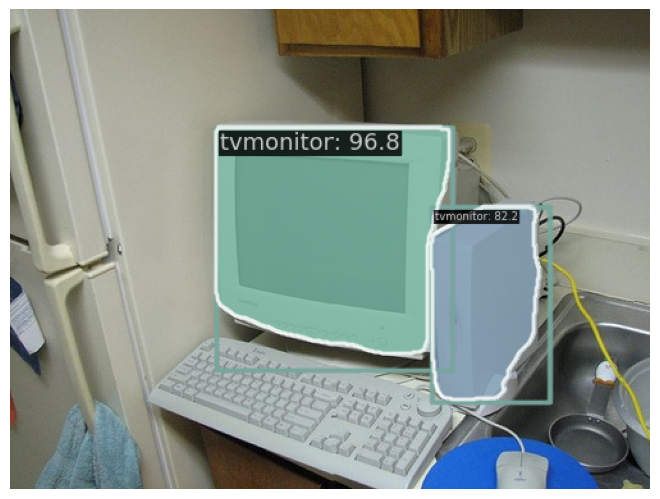

In [ ]:
from mmengine.visualization import Visualizer

# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    show=False,
    pred_score_thr=0.5
)
visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
